In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import nltk
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import umap

from pingouin import partial_corr

from mechir.data import CatDataCollator, DotDataCollator, MechDataset
import torch

from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader

from collections import Counter
import math

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

def process_frame(frame):

    output = {
        'qid': [],
        'query': [],
        'docno': [],
        'text': [],
        'perturbed': [],
    }

    for row in frame.itertuples():
        output['qid'].append(row.qid)
        output['query'].append(row.query)
        output['docno'].append(row.docno)
        output['text'].append(row.text)
        output['perturbed'].append(row.perturbed_text)
    
    return pd.DataFrame(output)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eickhoff/esx208/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 200
sim_fn = 'dot'

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_block_all.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"
doc_metrics_file = '/mnt/qb/work/eickhoff/esx208/MechIR/data/TFC1-data_w_metrics.tsv'
query_metrics_file = '/mnt/qb/work/eickhoff/esx208/MechIR/data/TREC-queries-data_w_metrics.tsv'

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('block_all', 'block_all_original_scores'))
perturbed_scores = np.load(data_path.replace('block_all', 'block_all_perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda text: text.rsplit(' ', 1)[-1])
doc_metrics_data = pd.read_csv(doc_metrics_file, sep='\t').drop_duplicates(subset=['docno'])
query_metrics_data = pd.read_csv(query_metrics_file, sep='\t').drop_duplicates(subset=['query_id'])
all_data_pd = all_data_pd.merge(doc_metrics_data, on=['docno'], suffixes=('', '_doc'))
all_data_pd = all_data_pd.merge(query_metrics_data, left_on=['qid'], right_on=['query_id'], suffixes=('', '_query'))

/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
processed_frame = process_frame(all_data_pd)
dataset = MechDataset(processed_frame, pre_perturbed=True)
collator = DotDataCollator(tokenizer, pre_perturbed=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collator, shuffle=False)

In [18]:
def segment_patching_results(dataloader, all_data_pd, patching_results, include_stopwords=True):
    patching_results_grouped = []
    for idx, batch in enumerate(tqdm(dataloader)):
        injected_term = all_data_pd.iloc[idx]['injected_term']
        injected_term_tokens = tokenizer(injected_term, add_special_tokens=False)['input_ids']
        query = all_data_pd.iloc[idx]['query']
        query_token_list = [tokenizer(term, add_special_tokens=False)['input_ids'] for term in query.split() if include_stopwords or term not in stopwords]
        
        curr_attn_mask = batch['perturbed_documents']['attention_mask'][0]
        curr_doc_toks = batch['perturbed_documents']['input_ids'][0][curr_attn_mask == 1]
        curr_patching_results = patching_results[idx, :, :, curr_attn_mask == 1].transpose(1, 2, 0)
        
        og_doc_start_idx = 1
        og_doc_end_idx = len(curr_doc_toks) - len(injected_term_tokens) - 2
        cls_tok_results = curr_patching_results[:, :, 0][:, :, np.newaxis]
        sep_tok_results = curr_patching_results[:, :, -1][:, :, np.newaxis]
        inj_tok_results = np.mean(curr_patching_results[:,:,og_doc_end_idx+1:-1], axis=-1)[:,:,np.newaxis]
        
        inj_tok_idxs = []
        non_inj_tok_idxs = []
        for query_tokens in query_token_list:
            for i in range(og_doc_start_idx, og_doc_end_idx + 1 - len(query_tokens)):
                window = curr_doc_toks[i:i + len(query_tokens)].tolist()
                if window == query_tokens:
                    window_range = range(i, i + len(query_tokens))
                    if window == injected_term_tokens:
                        inj_tok_idxs.extend(window_range)
                    else:
                        non_inj_tok_idxs.extend(window_range)
        
        if not inj_tok_idxs:
            q_term_inj_results = np.zeros((cls_tok_results.shape[0], cls_tok_results.shape[1], 1))
        else:
            q_term_inj_results = np.mean(curr_patching_results[:, :, inj_tok_idxs], axis=-1)[:,:,np.newaxis]
        if not non_inj_tok_idxs:
            q_term_non_inj_results = np.zeros((cls_tok_results.shape[0], cls_tok_results.shape[1], 1))
        else:
            q_term_non_inj_results = np.mean(curr_patching_results[:, :, non_inj_tok_idxs], axis=-1)[:,:,np.newaxis]
        
        all_doc_idxs = list(range(og_doc_start_idx, og_doc_end_idx + 1))
        non_q_term_idxs = list(set(all_doc_idxs) - set(inj_tok_idxs) - set(non_inj_tok_idxs))
        if not non_q_term_idxs:
            non_q_term_results = np.zeros((cls_tok_results.shape[0], cls_tok_results.shape[1], 1))
        else:
            non_q_term_results = np.mean(curr_patching_results[:, :, non_q_term_idxs], axis=-1)[:,:,np.newaxis]
        
        patching_results_grouped.append(np.concatenate([cls_tok_results, 
                                                        inj_tok_results, 
                                                        q_term_inj_results, 
                                                        q_term_non_inj_results, 
                                                        non_q_term_results, 
                                                        sep_tok_results], axis=-1))
    patching_results_grouped = np.array(patching_results_grouped)
    return patching_results_grouped

In [19]:
searcher = LuceneSearcher.from_prebuilt_index('msmarco-v1-passage-slim')
reader = IndexReader.from_prebuilt_index('msmarco-v1-passage-slim')

def get_tfidf(text, reader):
    terms = text.split()
    tf = Counter(terms)
    num_docs = reader.stats()['documents']
    
    tfidf_scores = dict()
    for term, term_count in tf.items():
        try:
            df = reader.get_term_counts(term)[0]
        except:
            df = 0
        if df > 0:
            tf = term_count / len(terms)
            idf = math.log(num_docs / df)
            tfidf_scores[term] = tf * idf
        else:
            tfidf_scores[term] = 0
    return tfidf_scores

def get_tf_injected_term(text, term):
    terms = text.split()
    tf = Counter(terms)
    if term in tf:
        return tf[term]
    else:
        return 0

def get_tfidf_injected_term(text, term, reader):
    tfidf_scores = get_tfidf(text, reader)
    if term in tfidf_scores:
        return tfidf_scores[term]
    else:
        return 0

In [20]:
all_data_pd['idf_injected_term'] = all_data_pd['injected_term'].apply(lambda x: get_tfidf(x, reader)[x])
all_data_pd['tf_injected_term'] = all_data_pd.apply(lambda x: get_tf_injected_term(x['text_tokenized'], x['injected_term']), axis=1)
all_data_pd['tfidf_injected_term'] = all_data_pd.apply(lambda x: get_tfidf_injected_term(x['text_tokenized'], x['injected_term'], reader), axis=1)
all_data_pd['injected_term_token_len'] = all_data_pd['injected_term'].apply(lambda x: len(tokenizer(x, add_special_tokens=False)['input_ids']))

In [23]:
def add_target_metrics(data, patching_results, original_scores, perturbed_scores):
    data['original_score'] = original_scores
    data['perturbed_score'] = perturbed_scores

    score_difference = perturbed_scores - original_scores
    data['score_delta'] = score_difference
    
    patching_results_unnormalised = patching_results - original_scores[:, np.newaxis, np.newaxis, np.newaxis]
    patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis, np.newaxis])))
    patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis, np.newaxis]))))
    
    patching_results_unnormalised_grouped = segment_patching_results(dataloader, all_data_pd, patching_results_unnormalised, include_stopwords=True)
    patching_results_normalised_grouped = segment_patching_results(dataloader, all_data_pd, patching_results_normalised, include_stopwords=True)
    patching_results_normalised_square_grouped = segment_patching_results(dataloader, all_data_pd, patching_results_normalised_square, include_stopwords=True)
    
    for idx, key in enumerate(['_resid_pre', '_attn_out', '_mlp_out']):
        data['patching_effect_std' + key] = np.std(patching_results_unnormalised_grouped, axis=(-1,-2))[:, idx]
        data['patching_effect_absolute_mean' + key] = np.mean(np.abs(patching_results_unnormalised_grouped), axis=(-1,-2))[:, idx]
        data['patching_effect_normalised_std' + key] = np.std(patching_results_normalised_grouped, axis=(-1,-2))[:, idx]
        data['patching_effect_normalised_absolute_mean' + key] = np.mean(np.abs(patching_results_normalised_grouped), axis=(-1,-2))[:, idx]
        data['patching_effect_normalised_square_std' + key] = np.std(patching_results_normalised_square_grouped, axis=(-1,-2))[:, idx]
        data['patching_effect_normalised_square_absolute_mean' + key] = np.mean(np.abs(patching_results_normalised_square_grouped), axis=(-1,-2))[:, idx]
    
    return data

In [24]:
add_target_metrics(all_data_pd, patching_results, original_scores, perturbed_scores);

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

(4000, 3, 6, 6) (4000, 3, 6, 6) (4000, 3, 6, 6)


In [25]:
def plot_relationship_continous_colorbar(x, y, hue, data, title="", xlabel="", ylabel=""):
    plt.figure(figsize=(10, 6))
    scatter_plot = sns.scatterplot(data=data, x=x, y=y, hue=hue, palette='viridis', legend=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    norm = plt.Normalize(data[hue].min(), data[hue].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    scatter_plot.figure.colorbar(sm, label=hue, orientation='vertical', ax=scatter_plot)
    plt.show()

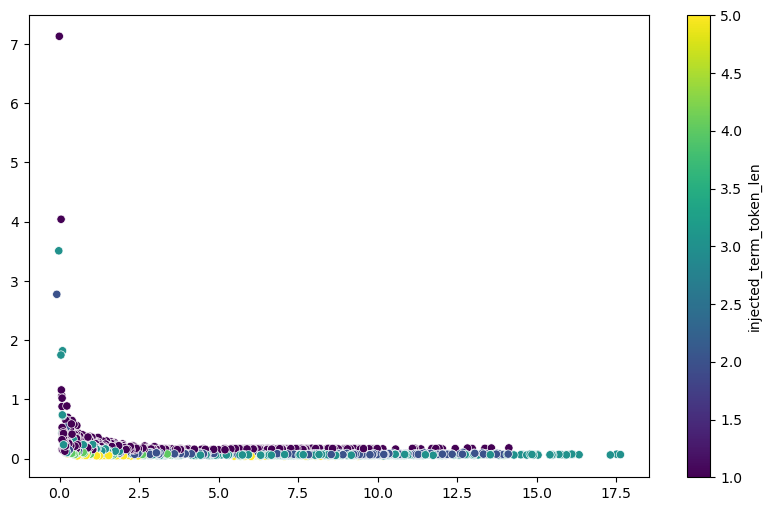

In [26]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_normalised_absolute_mean_resid_pre', 'injected_term_token_len', all_data_pd)

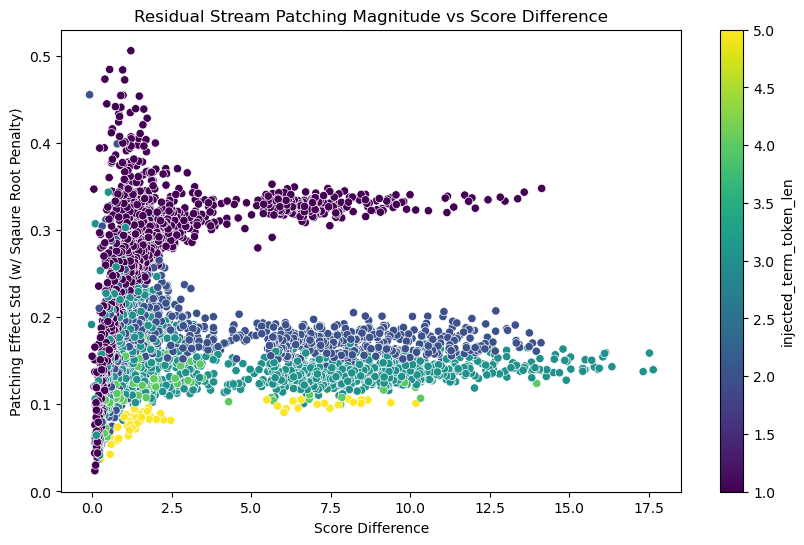

In [46]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_normalised_square_std_resid_pre', 'injected_term_token_len', all_data_pd, title='Residual Stream Patching Magnitude vs Score Difference', xlabel='Score Difference', ylabel='Patching Effect Std (w/ Sqaure Root Penalty)')

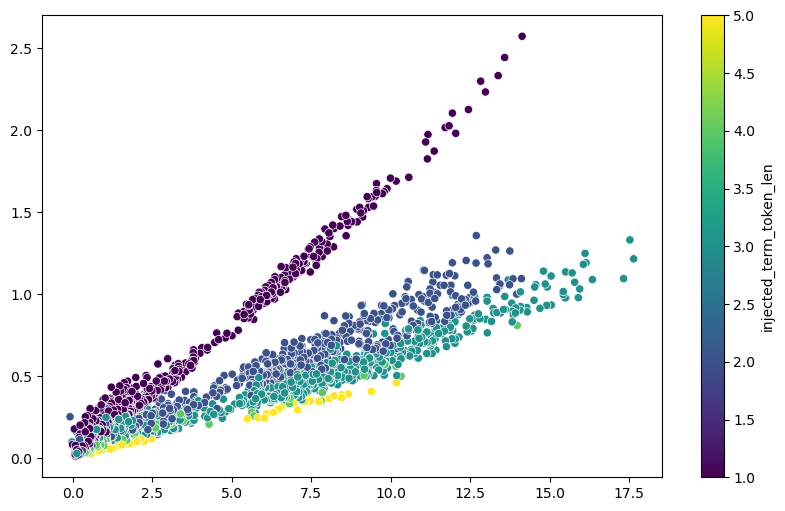

In [27]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_absolute_mean_resid_pre', 'injected_term_token_len', all_data_pd)

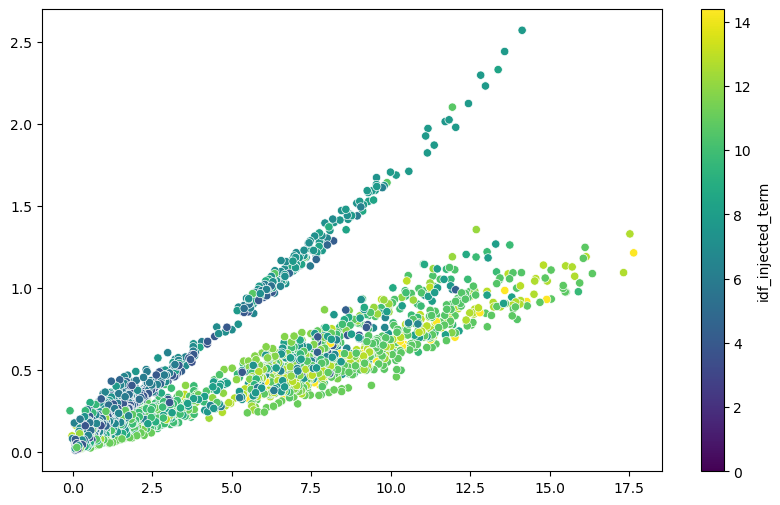

In [28]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_absolute_mean_resid_pre', 'idf_injected_term', all_data_pd)

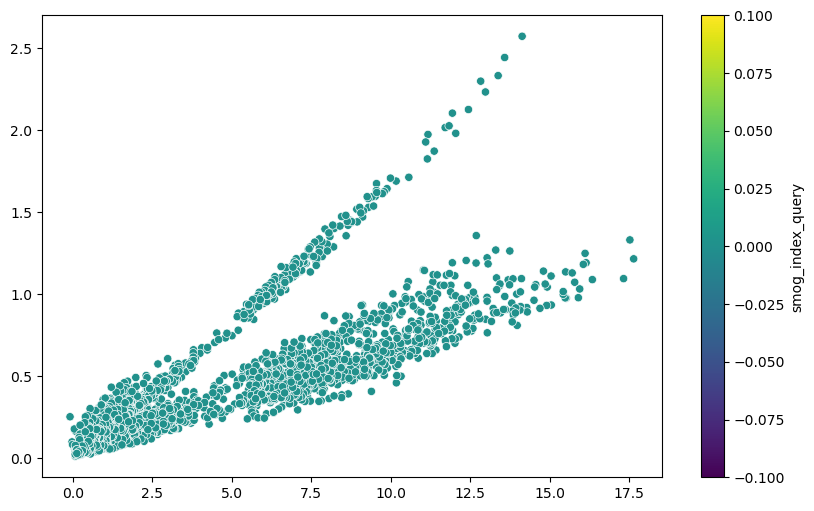

In [29]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_absolute_mean_resid_pre', 'smog_index_query', all_data_pd)

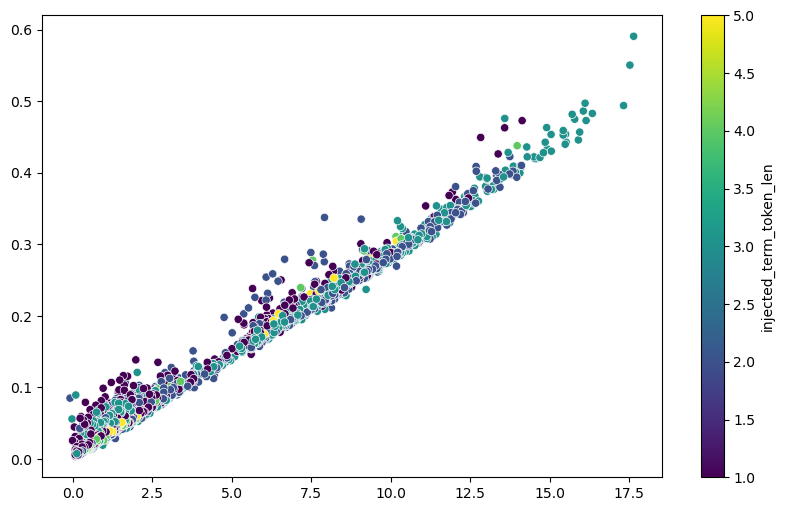

In [30]:
plot_relationship_continous_colorbar('score_delta', 'patching_effect_absolute_mean_attn_out', 'injected_term_token_len', all_data_pd)

In [39]:
def output_partial_correlations(properties, target_metrics, data):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            if property != 'score_delta':
                spearman_partial = partial_corr(data=all_data_pd, x=target_metric, y=property, covar=['score_delta'], method='spearman')
                correlations[target_metric][property] = {'spearman_partial': np.round(spearman_partial['r'].values[0], 3), 
                                                        'p-value': np.round(spearman_partial['p-val'].values[0], 3)}
    return pd.DataFrame(correlations)


target_metrics = ['patching_effect_std_resid_pre', 'patching_effect_absolute_mean_resid_pre']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'injected_term_token_len', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_partial_correlations(properties, target_metrics, all_data_pd)
# correlations_table.rename(columns={'patching_effect_std_resid_pre': 'Std of Unnormalised Patching Effect Resid Pre',
#                                    'patching_effect_absolute_mean_resid_pre': 'Mean Absolute Unnormalosed Patching Effect Resid Pre'}, inplace=True)
correlations_table = correlations_table.sort_values(by=target_metrics[0], key=lambda x: x.apply(lambda y: -np.abs(y['spearman_partial'])))

/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


In [40]:
correlations_table

,patching_effect_std_resid_pre,patching_effect_absolute_mean_resid_pre
injected_term_token_len,"{'spearman_partial': -0.705, 'p-value': 0.0}","{'spearman_partial': -0.654, 'p-value': 0.0}"
idf_injected_term,"{'spearman_partial': -0.365, 'p-value': 0.0}","{'spearman_partial': -0.3, 'p-value': 0.0}"
coleman_liau_index_query,"{'spearman_partial': -0.199, 'p-value': 0.0}","{'spearman_partial': -0.185, 'p-value': 0.0}"
automated_readability_index_query,"{'spearman_partial': -0.187, 'p-value': 0.0}","{'spearman_partial': -0.177, 'p-value': 0.0}"
tfidf_std_query,"{'spearman_partial': -0.178, 'p-value': 0.0}","{'spearman_partial': -0.194, 'p-value': 0.0}"
tfidf_mean_query,"{'spearman_partial': -0.176, 'p-value': 0.0}","{'spearman_partial': -0.163, 'p-value': 0.0}"
smog_index,"{'spearman_partial': -0.147, 'p-value': 0.0}","{'spearman_partial': -0.16, 'p-value': 0.0}"
relevance,"{'spearman_partial': -0.145, 'p-value': 0.0}","{'spearman_partial': -0.135, 'p-value': 0.0}"
flesch_reading_ease_query,"{'spearman_partial': 0.144, 'p-value': 0.0}","{'spearman_partial': 0.139, 'p-value': 0.0}"
dale_chall_readability_score_query,"{'spearman_partial': -0.139, 'p-value': 0.0}","{'spearman_partial': -0.125, 'p-value': 0.0}"


In [37]:
target_metrics = ['patching_effect_std_attn_out', 'patching_effect_absolute_mean_attn_out']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'injected_term_token_len', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_partial_correlations(properties, target_metrics, all_data_pd)
# correlations_table.rename(columns={'patching_effect_std_resid_pre': 'Std of Unnormalised Patching Effect Resid Pre',
#                                    'patching_effect_absolute_mean_resid_pre': 'Mean Absolute Unnormalosed Patching Effect Resid Pre'}, inplace=True)
correlations_table = correlations_table.sort_values(by=target_metrics[0], key=lambda x: x.apply(lambda y: -np.abs(y['spearman_partial'])))

/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


In [38]:
correlations_table

,patching_effect_std_attn_out,patching_effect_absolute_mean_attn_out
dale_chall_readability_score_query,"{'spearman_partial': -0.214, 'p-value': 0.0}","{'spearman_partial': -0.033, 'p-value': 0.039}"
tfidf_mean_query,"{'spearman_partial': -0.203, 'p-value': 0.0}","{'spearman_partial': 0.031, 'p-value': 0.05}"
idf_injected_term,"{'spearman_partial': -0.187, 'p-value': 0.0}","{'spearman_partial': 0.221, 'p-value': 0.0}"
injected_term_token_len,"{'spearman_partial': -0.156, 'p-value': 0.0}","{'spearman_partial': 0.089, 'p-value': 0.0}"
tfidf_std_query,"{'spearman_partial': -0.155, 'p-value': 0.0}","{'spearman_partial': 0.002, 'p-value': 0.921}"
automated_readability_index_query,"{'spearman_partial': -0.125, 'p-value': 0.0}","{'spearman_partial': -0.016, 'p-value': 0.324}"
flesch_reading_ease_query,"{'spearman_partial': 0.125, 'p-value': 0.0}","{'spearman_partial': 0.038, 'p-value': 0.016}"
smog_index,"{'spearman_partial': -0.112, 'p-value': 0.0}","{'spearman_partial': -0.16, 'p-value': 0.0}"
coleman_liau_index_query,"{'spearman_partial': -0.106, 'p-value': 0.0}","{'spearman_partial': -0.009, 'p-value': 0.586}"
tfidf_mean,"{'spearman_partial': 0.064, 'p-value': 0.0}","{'spearman_partial': 0.125, 'p-value': 0.0}"


In [35]:
target_metrics = ['patching_effect_std_mlp_out', 'patching_effect_absolute_mean_mlp_out']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'injected_term_token_len', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_partial_correlations(properties, target_metrics, all_data_pd)
# correlations_table.rename(columns={'patching_effect_std_resid_pre': 'Std of Unnormalised Patching Effect Resid Pre',
#                                    'patching_effect_absolute_mean_resid_pre': 'Mean Absolute Unnormalosed Patching Effect Resid Pre'}, inplace=True)
correlations_table = correlations_table.sort_values(by=target_metrics[0], key=lambda x: x.apply(lambda y: -np.abs(y['spearman_partial'])))

/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1112488/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


In [36]:
correlations_table

,patching_effect_std_mlp_out,patching_effect_absolute_mean_mlp_out
smog_index,"{'spearman_partial': -0.199, 'p-value': 0.0}","{'spearman_partial': -0.232, 'p-value': 0.0}"
injected_term_token_len,"{'spearman_partial': -0.186, 'p-value': 0.0}","{'spearman_partial': -0.17, 'p-value': 0.0}"
tfidf_injected_term,"{'spearman_partial': 0.176, 'p-value': 0.0}","{'spearman_partial': 0.266, 'p-value': 0.0}"
idf_injected_term,"{'spearman_partial': -0.151, 'p-value': 0.0}","{'spearman_partial': -0.132, 'p-value': 0.0}"
tfidf_mean,"{'spearman_partial': 0.146, 'p-value': 0.0}","{'spearman_partial': 0.186, 'p-value': 0.0}"
tf_injected_term,"{'spearman_partial': 0.14, 'p-value': 0.0}","{'spearman_partial': 0.222, 'p-value': 0.0}"
dale_chall_readability_score,"{'spearman_partial': 0.114, 'p-value': 0.0}","{'spearman_partial': 0.147, 'p-value': 0.0}"
english_probability_query,"{'spearman_partial': -0.113, 'p-value': 0.0}","{'spearman_partial': -0.111, 'p-value': 0.0}"
gpt2_perplexity,"{'spearman_partial': 0.102, 'p-value': 0.0}","{'spearman_partial': 0.135, 'p-value': 0.0}"
gunning_fog,"{'spearman_partial': 0.098, 'p-value': 0.0}","{'spearman_partial': 0.119, 'p-value': 0.0}"
